# Preparations

## Check the python system

In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))

Python 3.6.3 (default, Nov 17 2017, 13:39:09) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.38)] on darwin


## Check for Keras backend
Keras comes with three different backends:
* Theano
* Tensorflow
* CNTK

In short, Keras allows you to write high-level code that can then be executed by the framework of your choice (or that of your admin's choice...)
For changing the Keras backend, we must access the KERAS_BACKEND environment variable. Allowed values obviously are:
* theano
* tensorflow
* cntk.

In [2]:
import os
# set the environment variable
os.environ["KERAS_BACKEND"] = "tensorflow"
# make sure we were successful
print(os.environ.get("KERAS_BACKEND"))


tensorflow


## Initialize tensorflow
This is tensorflow specific (and also only needed when working on actual GPUs) but useful to know. 
By default, tensorflow reserves _all_ memory on _all_ graphic cards it finds on a machine.
If you are not the only user (and this will often be the case) this behavior can be painful for all other users.
Setting the allow_growth option to true will prevent this from happening.

In [3]:
# import the tensorflow library
import tensorflow as tf
# create a configuration protocol
config = tf.ConfigProto()
# set the allow_growth option to true in the protocol
config.gpu_options.allow_growth = True
# start a sesstion that uses the configuration protocol
session = tf.Session(config=config)


## Import the relevant libraries
These are
* the keras.models submodule (acts as a container for keras networks)
* the keras.layers submodule (here the different types of network layers are defines)
* numpy for numerical operations
* the confusion_matrix function from sklearn.metrics for evaluation (more on that later)
* urllib for loading the data

In [4]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
from sklearn.metrics import confusion_matrix
import urllib

Using TensorFlow backend.


## Fix a seed
For reproducability, it is a good idea to give the random number generator a fixed seed.

Why? As you will see below, we initialize the weights in our layers randomly by using a uniform distribution.
By fixing a seed, the "random" process will always be the same as long as we execute the code in the same order.

In [5]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)


## Loading the data
For our first example, we will use the Pima Native Americans Diabetes data set (more on this at the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes)).

As is usual in ML applications, the data set comes as a large $N\times D$ matrix where $N$ denotes the number of samples we have and $D$ is the number of dimensions per sample.
Note that in this case, the number of features for a single data point is only $D-1$ since the last column is the class variable that we are trying to predict.

For the current data set, the columns are as follows:
1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 or 1)

In [6]:
# load dataset from the URL
url = 'https://github.com/RaikOtto/DeepLearningTutorial/raw/master/pima-indians-diabetes.csv'
response = urllib.request.urlopen( url )
dataset = numpy.loadtxt(response, delimiter=",")


### Create input and output data
As said, the input features are the first $D-1$ columns of our data set and the response (or class or label, you name it) is the $D^{\text{th}}$ column. In our example, we have $D=9$, so column $1$ to $8$ should go int the training data $X$ and the last into the label data $Y$.

Note a python subtlety: the range ```0:8``` will exclude the right bound, i.e. will go from $0$ to $7$ (but will be comprised of eight numbers).
The ninth column is the class variable and will go into output $Y$.

In [7]:
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]


# Create first network with Keras
We are now done with preparing the data and it is time to construct our first network structure.

To begin with, we are building a simple linearly stacked sequence of layers into a model structure.
For this we can use the ```Sequential()``` container. More complicated models (e.g. with multiple input sources or multiple output values) can be programatically constructed by using Keras' functional Model class API.

In [8]:
# create model
model = Sequential()

What do we know about the data so far?

* we know that we have 8 input feature dimensions (matching the values in columns 1-8 described above)
* we know that we have a single output value which is either $0$ or $1$

The first fact is encoded in the first call to the ```model.add``` function, which adds new layers to the sequential model.

In [9]:
model.add(Dense(12, input_dim=8, kernel_initializer='random_normal', activation='relu'))

### Layer structure
The above code tells us that we have $8$ input features and so our input layer to the network will have $8$ nodes.
The first hidden layer consists of $12$ nodes and is densely connected to the input (signified by the ```Dense``` layer class we are using to create the layer) meaning that every input layer node is connected to every node in the hidden layer.

### Weight initialization
Each if these connections has a weight parameter that gets initialized when the layer is constructed. We are using the ```random_uniform``` initializer here, meaning that each weight will get a random value according to a draw from a uniform distribution on $[0,1]$. 

There are many other initializers that you can experiment with. Sometimes, changing an initilizer will give you better performance or faster convergence. To some degree, you can use initializers to help the model learn by using them to incoporate prior knowledge on how the weights should look like.

Other intializers include:
* setting all weights to zeros ```zeros```
* setting all weights to ones ```ones```
* setting weights randomly according to a normal distribution ```random_normal```
* and quite a few others, see the [Keras documentation](https://keras.io/initializers/) for more.

### Activation function
Note that we have set the ```activation``` property of the layer to ```relu```. This indicates that we want to use the Rectified Linear Unit activation function in the hidden layer.
By default, the input values are propagated through the input layer.

In general however, we build a weighted sum over the outputs of the previous layer that are connected to a node in the current layer which then serves as the input to the node. As we are dealing with a densely connected hidden layer at the moment, this is simply a weighted sum over all inputs for each node:
$$\text{input}^{\text{layer j}}(o^{\text{layer j-1}}) = \sum_{i=1}^{N_{j-1}} w_{ij} o_i^{j-1}$$
where $N_{j-1}$ is the number of nodes in layer $j-1$.

The output of a node in layer $j$ is then given as the activation function evaluated at the input to the node, i.e.
$$o_k^{j} = f_{\text{act}}(\text{input}_k^{\text{layer j}})$$
where $f_{\text{act}}(\cdot)$ is the _activation function_.

While the rectified function is arguably the most prominent and popular activation function, there are tons of other activation functions that may be used.
These include:
* the logistic function see ```sigmoid``` below
* the hyperbolic tangent
* the arc tangens function
* the exponential linear unit
* and many others, see [the Wiki article](https://en.wikipedia.org/wiki/Activation_function) for a nice overview.

Next, we are adding another hidden layer (remember, we want to be deeep). 

### Intermediate hidden layer
The number of nodes in this layer is fairly random. In general, recall that we are trying to learn distributional representations of the data, i.e. as we traverse the layers, we want to find more abstract representations of the data. For this, it can be useful to blow up the space (in our case from $8$ to $12$ dimensions) in which the data can be represented. We then narrow the space again, to group discriminatory attributes from the higher-dimensional space to finally do the regression or classification task at hand.

Again, the layer is going to be densely connected to the underlying hidden layer and is initialized using the ```random_uniform``` function. Also, it uses the ```relu``` activation again.

In [10]:
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))

### Crafting the output layer
Remember that we know from inspecting the data set that we are dealing with a classification task and that there is exactly one class variable that we are trying to predict.

This knowledge dictates the structure of the output layer. We will have a single node in this layer. Again, we are using a dense layer, i.e. we connect each node from the underlying hidden layer to the output node. And we will use a different activation function, the ```sigmoid``` (or logistic) that will produce a value in $[0,1]$ that can be interpreted as the predicted probability that the class variable will be one.

In the actual prediction task we can use this number to decide for class assignment to class $1$ if the output is larger than $0.5$ or to class $0$ if the value is below that.

In [11]:
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

## Compiling the model
After we have added layers to our sequential model, we need to compile the model by calling the ```compile``` function and providing a loss function and an optimizer.

### The loss function
The loss function is the objective that gets optimized by the optimizer. In general, the loss function is a function $$\ell: \mathcal Y \times \mathcal Y \to \mathbb R,$$
taking the true output value and the predicted value (both of which are elements of the output space $\mathcal Y$) and computing a _loss_. Obviously, the loss becomes $0$ as soon as the predicted value is equal to the true value.

In our particular example, we use the ```binary_crossentropy``` loss function. In short, this is the negative logarithm of the predicted probability of seeing one multiplied by the actual probability of the class being $1$, i.e. this value is either $0$ or $1$.
This type of loss particularly penalizes confident decisions that are wrong.
![Binary cross-entropy loss](http://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png)

The choice of the loss function heavily depends on the structure of the data and the type of task to solve (e.g. regression, classification, clustering etc.)

Available loss functions can be found [here](https://keras.io/losses/). The [ML cheat sheet](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) also gives a nice overview with links to further information.

### The optimizer
The goal of learning in DNNs (and ANNs as well) is to readjust the weights so that the loss gets smaller (i.e. is minimized). We do this by computing the gradients of the loss function w.r.t. the weights in the networks.
While we would need the whole data set to compute one gradient step (the loss function depends on all data points in the data set), we usually use optimizers based on stochastic gradient descent in modern DNN applications.

Adam, again as one of the most popular algorithms, combines several advantages of other approaches.

First, it operates on _mini batches_ of data, i.e. it takes only a subset of the available data points and then computes a noisy estimate of the overall gradient. Weights are then updated using this noisy estimate weighted by a learning rate (this is simple stochastic gradient descent). In Adam, each of the weights has its own learning rate, which at the same time is adapted to the data (this is special to Adam).

Secondly, Adam uses a moving average over the gradients of the last mini batch iterations, making it more stable in very noisy data regimes. Additionally to moving averages over the mean values of the gradients (which RMSProp uses as well), Adam also keeps track of a moving average over the variance of the gradient in a mini batch and uses this as well for adapting the learning rates.

Other available optimizers can be found [here](https://keras.io/optimizers/).

In [12]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

### Metrics
Additional to the required arguments of loss and optimizer, we also provide a ```metrics``` argument that tells the model that we want to keep track of the ```accuracy``` of the network during training and testing. We will see how that works below.

## Training the network
With a simple call to the ```model.fit``` function, we train the DNN. For this, we provide the training inputs ```X```, the desired outputs ```Y```, the number of ```epochs```, the ```batch_size``` and a level of verbosity.
While the input and output should be clear, ```epochs``` tells the model how many times we should traverse the training data set during training and ```batch_size``` tells the optimizer, how many data points it should include in one _mini batch_. The ```verbose``` argument simply tells the framework how much information you want to see during training.

**Warning: this may take a moment!**

In [13]:
# Fit the model
history = model.fit(
    X,
    Y,
    epochs=1000,
    batch_size=10,
    verbose=2)


Epoch 1/1000
 - 1s - loss: 0.6788 - acc: 0.6510
Epoch 2/1000
 - 0s - loss: 0.6519 - acc: 0.6510
Epoch 3/1000
 - 0s - loss: 0.6371 - acc: 0.6510
Epoch 4/1000
 - 0s - loss: 0.6310 - acc: 0.6510
Epoch 5/1000
 - 0s - loss: 0.6231 - acc: 0.6510
Epoch 6/1000
 - 0s - loss: 0.6123 - acc: 0.6510
Epoch 7/1000
 - 0s - loss: 0.6147 - acc: 0.6510
Epoch 8/1000
 - 0s - loss: 0.6104 - acc: 0.6510
Epoch 9/1000
 - 0s - loss: 0.6039 - acc: 0.6510
Epoch 10/1000
 - 0s - loss: 0.6094 - acc: 0.6510
Epoch 11/1000
 - 0s - loss: 0.5997 - acc: 0.6510
Epoch 12/1000
 - 0s - loss: 0.5972 - acc: 0.6510
Epoch 13/1000
 - 0s - loss: 0.5969 - acc: 0.6510
Epoch 14/1000
 - 0s - loss: 0.5941 - acc: 0.6510
Epoch 15/1000
 - 0s - loss: 0.5928 - acc: 0.6510
Epoch 16/1000
 - 0s - loss: 0.5942 - acc: 0.6510
Epoch 17/1000
 - 0s - loss: 0.5917 - acc: 0.6510
Epoch 18/1000
 - 0s - loss: 0.5992 - acc: 0.6510
Epoch 19/1000
 - 0s - loss: 0.5914 - acc: 0.6510
Epoch 20/1000
 - 0s - loss: 0.5943 - acc: 0.6510
Epoch 21/1000
 - 0s - loss: 0

## Evaluating the outcome
After training, we of course want to know, how well we are doing on the data set.
For this, we may call the ```model.evaluate``` method which takes in again a number of inputs and outputs and reports the ```loss``` and ```accuracy``` of the network after training.

In [14]:
# Evaluate the network
loss, accuracy = model.evaluate(X, Y)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))


768/768 [==============================] - 0s 61us/step

Loss: 0.37, Accuracy: 83.59%


## Plotting
Notice that we have stored the fit in a ```history``` variable. This gives us a nice way of visualizing the behavior of the model during training w.r.t. the loss and the recorded metric, both of which can be accessed via ```history.history['loss']``` and ```history.history['accuracy']``` respectively.

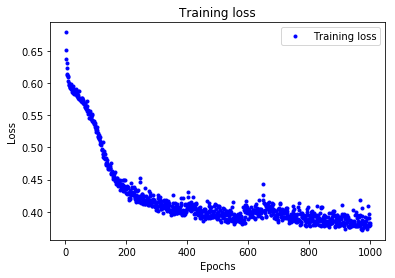

In [15]:
# loss function
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b.', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


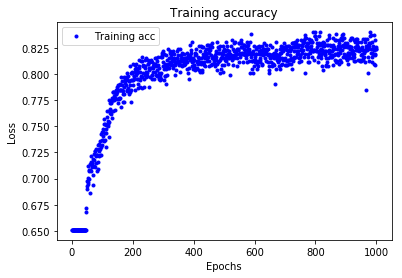

In [16]:
# accuracy

plt.clf()   # clear figure

acc = history.history['acc']

plt.plot(epochs, acc, 'b.', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Precision and Recall
Finally, we might want to compute other task specific measures. For this binary classification task, this could be the precision and recall or the F-measure.

For this, we need to compute the precision matrix. This can easily be done by 
1. computing the probabilities for class assignment for every input $X$
2. deciding for the assigned class label (if probability > $0.5$ assign class $1$, assign class $0$ otherwise)
3. call the ```confusion_matrix``` method from ```sklearn```, it expects the true outcome and the predictions as input and produces a confusion matrix (who would have thought).

The confusion matrix has the following form

|true negatives|false positives|
|---|---|
|**false negatives**|**true positives**|

In [22]:
# calculate predictions
probabilities = model.predict(X)
predictions = [float(x>0.5) for x in probabilities]

cm = confusion_matrix(Y, predictions)

tp = float(cm[1,1])
fp = float(cm[0,1])
tn = float(cm[0,0])
fn = float(cm[1,0])
print ("True positives:  %.0f" % tp)
print ("False positives: %.0f" % fp)
print ("True negatives:  %.0f" % tn)
print ("False negatives: %.0f" % fn)

prec = tp/(tp+fp)
rec = tp/(tp+fn)
f1 = (2*prec*rec)/(prec+rec)
print ("Precision: %.3f" % prec)
print ("Recall: %.3f" % rec)
print ("F1: %.3f" % f1)

True positives:  219
False positives: 77
True negatives:  423
False negatives: 49
Precision: 0.740
Recall: 0.817
F1: 0.777
